In [348]:
import pathlib

import yaml

import numpy as np

import itertools

In [349]:
from pixell import enmap, utils as putils

In [350]:
import utilities as u

In [351]:
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.figsize'] = [12, 8]

csfont = {'fontname':'cmss10'}
font = font_manager.FontProperties(family='Latin Modern Roman',
                                   style='normal', size = 8)


In [352]:
import best
import re

In [353]:
values_file = 'configurations/configILC.yaml' 
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)

In [354]:


plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())


lista_lmaxes = []

names = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

In [355]:
nu

'ilc'

In [356]:
noisetag = data['noisekey']
trispectrumtag = data['trispectrumkey']
primarytag = data['primarykey']
secondarytag = data['secondarykey']
primarycrosstag = data['primarycrosskey']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [357]:
colors_ests = {}
labels_ests = {}
for e in estimators:
    colors_ests[e] = estimators_dictionary[e]['color']
    labels_ests[e] = estimators_dictionary[e]['label']

In [358]:
noisebiasconstr = False

In [359]:
results_directory = data['resultsdirectory']
results_directory

'resultssumfg_ILC_0203/'

In [360]:
get_dir = lambda s, b, sy, p: f's{s}b{b}sy{sy}p{p}'

In [361]:
path = pathlib.Path(analysis_directory)
l = 3500
all_lmaxes_directories =  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(l, l, l, l))]

In [362]:
kk = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'kk_ilc.npy')
theta = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'theta_ilc.npy')
ells = np.load(pathlib.Path(analysis_directory)/get_dir(l, l, l, l)/'ells_ilc.npy')
selection = (ells > 30) & (ells < 1200)

In [363]:
resultspath = pathlib.Path(results_directory)

In [364]:
def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

In [365]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar)

In [366]:
fb = 1.
invvariance = False

In [367]:
reference_directory = pathlib.Path('output_ILC_0203/h3000s3000b3000p3000sy3000/total/')

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy']
Optimizerkk = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
x_estimator = get_est_weights(Optimizerkk, index = 0)
f, n, b = fnb_getter(Optimizerkk, fb, True)
f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)

In [368]:
def get_info(directory):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/'w_auto_fb_1.0.npy')
    x = np.load(resultspath/directory/'x_auto_fb_1.0.npy')
    return kk, theta, ells, biases, noises, w, x

In [369]:
all_combs_array = np.zeros((3, len(all_lmaxes_directories)))

all_results_single_array = np.zeros((len(estimators), 3, len(all_lmaxes_directories)))

for numdir, directory in enumerate(all_lmaxes_directories):

    kk, theta, ells, biases, noises, w, x = get_info(directory)
    
    ells_selected = w[0]
    names = ['Shear', 'BH', 'SY', 'PBH']
    colors = ['red', 'green', 'orange', 'purple']


    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)

    Nestimators = len(Optimizerkk.estimators)

    for index in range(Nestimators):
        x_estimator = get_est_weights(Optimizerkk, index = index)
        f, n, b = fnb_getter(Optimizerkk, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)
        all_results_single_array[index, :, numdir] = np.array([f_estimator, n_estimator, b_estimator])

    f, n, b = fnb_getter(Optimizerkk, fb, invvariance)
    fcomb, ncomb, bcomb = f(x), n(x), b(x)
    
    all_combs_array[:, numdir] = np.array([fcomb, ncomb, bcomb])

In [370]:
all_combs_array_lista = list(all_combs_array[0, :])

In [371]:
minimo = np.min(all_combs_array[0, :])
indmin = all_combs_array_lista.index(minimo)

In [372]:
directory = all_lmaxes_directories[indmin]
directory

's3000b3500sy3500p4000'

In [397]:
def do_all(directory):
    kk, theta, ells, biases, noises, w, x = get_info(directory)

    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, biases, noises)
    
    Nestimators = len(Optimizerkk.estimators)
    Ne = Nestimators
    results_array = np.zeros((3, Nestimators+1))
    for index in range(Nestimators):
        x_estimator = get_est_weights(Optimizerkk, index = index)
        a_estimate = Optimizerkk.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)
        results_array[:, index+1] = np.array([f_estimator, n_estimator, b_estimator])

    a = np.c_[w[1:5]].T
    wl = w[-1]
    combinedn = Optimizerkk.get_bias_part(a, Optimizerkk.noises_selected)
    combinedb = Optimizerkk.get_bias_part(a, Optimizerkk.biases_selected)

    combinedtheta = Optimizerkk.get_variance_part(a, Optimizerkk.theta_selected)

    Optimizerkk_abs = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    f, n, b = fnb_getter(Optimizerkk_abs, fb, invvariance)
    fcomb_abs, ncomb_abs, bcomb_abs = f(x), n(x), b(x)

    combinedb_abs = Optimizerkk_abs.get_bias_part(a, Optimizerkk_abs.biases_selected)
    combinedb_abs = combinedb_abs*bcomb_abs/Optimizerkk_abs.theory_selected


    ells = Optimizerkk.ells_selected
    kk = Optimizerkk.theory_selected
    Ne = len(Optimizerkk.estimators)


    names = ['Shear', 'BH', 'SY', 'PBH']
    colors = ['red', 'green', 'orange', 'purple']

    height_ratios = [1, 1, 3, 1, 1, 1]
    fig, ax = plt.subplots(nrows = 6, sharex = True, figsize = (15, 10), gridspec_kw = {'height_ratios': height_ratios})
    fig.suptitle(f'Case of fb = {fb}, best directory {directory}')
    ax[0].plot(ells, combinedb/kk, color = 'black', label = 'Combined', marker = 'o')

    for i in range(Ne):
        ax[0].plot(ells, Optimizerkk.biases_selected[i, i]/kk, color = colors[i], label = names[i])
    ax[0].plot(ells, ells*0, color = 'black', ls = '--')
    ax[0].legend(loc = 'best', ncol = len(names)+1)


    for i in range(Ne):
        ax[1].plot(ells, (Optimizerkk.theta_selected[i, i, i, i]/kk**2)**-1., color = colors[i])

    ax[1].plot(ells, (combinedtheta/kk**2)**-1., color = 'black', marker = 'o')
    ax[1].plot(ells, ells*0, color = 'black', ls = '--')

    #ax[2].plot(ells, wl**2*(combinedtheta/kk**2), color = 'black', ls = ':', label = 'Combined variance contr per L')
    #ax[2].plot(ells, wl*combinedb_abs, color = 'black', ls = '-.', label = 'Combined bias contr per L')
    
    
    listatemp = []
    for index in range(Ne):
        x_estimator = get_est_weights(Optimizerkk_abs, index = index)
        a_estimate = Optimizerkk_abs.get_a(x_estimator, True)
        f, n, b = fnb_getter(Optimizerkk_abs, fb, True)
        f_estimator, n_estimator, b_estimator = f(x_estimator), n(x_estimator), b(x_estimator)

        combinedn_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.noises_selected)
        combinedb_example = Optimizerkk_abs.get_bias_part(a_estimate, Optimizerkk_abs.biases_selected)
        b_example = b_estimator

        combinedb_abs_example = combinedb_example*b_example/Optimizerkk_abs.theory_selected

        theta_example = Optimizerkk_abs.theta_selected[index, index, index, index]
        wl_example = Optimizerkk_abs.get_mv_weights(Optimizerkk_abs.ells_selected, Optimizerkk_abs.theory_selected, variance)

        print(f'Example is for {Optimizerkk.estimators[index]}')

        #ax[2].plot(ells, wl_example**2*(theta_example/kk**2), color = colors[index], ls = ':')
        #ax[2].plot(ells, wl_example*combinedb_abs_example, color = colors[index], ls = '-.')
        ax[2].plot(ells, wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example, color = colors[index], ls = ':')
        listatemp += [wl_example**2*(theta_example/kk**2)+wl_example*combinedb_abs_example]
    print(np.array(listatemp).shape)
    inv = np.array(listatemp)**-1.
    print(np.array(listatemp)/np.sum(np.array(listatemp), axis = 0))
    print(inv/np.sum(np.array(inv), axis = 0))
    
    ax[2].plot(ells, wl**2*(combinedtheta/kk**2)+wl*combinedb_abs)
        
        
    ax[2].plot(ells, ells*0, color = 'black', ls = '--')
    ax[2].legend(loc = 'best', ncol = 2)

    ax[3].plot(ells, ells*0, color = 'black', ls = '--')
    ax[5].plot(ells, ells*0, color = 'black', ls = '--')
    for i in range(Ne):
        ax[3].plot(ells, w[1+i], color = colors[i])
        ax[5].plot(ells, w[1+i]*wl*ells, color = colors[i])

    ax[4].plot(ells, wl, color = 'black')
    ax[4].plot(ells, ells*0., color = 'black', ls = '--')

    ax[0].set_ylabel('$\\frac{B}{C_L}$', size = 15)
    ax[1].set_ylabel('$(\\frac{\sigma^2}{C_L^2})^{-1}$', size = 15)
    ax[2].set_ylabel('$W_L\\mathrm{comb}$', size = 15)
    ax[3].set_ylabel('$W$', size = 15)
    ax[4].set_ylabel('$W_L$', size = 15)
    ax[-1].set_ylabel('$LW_LW$', size = 15)

    ax[0].set_xscale('log')
    ax[-1].set_xlabel('$L$')

In [398]:
directory

's3000b3500sy3500p4000'

No handles with labels found to put in legend.


Example is for shear
Example is for bh
Example is for symm
Example is for pbh
(4, 8)
[[0.12519977 0.11994113 0.19794103 0.22639821 0.36077656 0.32976763
  0.35123569 0.40536747]
 [0.32399547 0.24150873 0.28317137 0.24600216 0.1624662  0.06059728
  0.1072169  0.08145356]
 [0.38264602 0.54747113 0.44409792 0.44827394 0.36905187 0.31068713
  0.29146499 0.28279445]
 [0.16815874 0.091079   0.07478967 0.07932569 0.10770537 0.29894797
  0.25008243 0.23038453]]
[[0.4068096  0.3297494  0.20870875 0.1894159  0.13248781 0.11619176
  0.14523304 0.10905565]
 [0.15720117 0.16376433 0.14589055 0.17432131 0.2942058  0.63231029
  0.47577413 0.54273395]
 [0.13310597 0.0722422  0.09302459 0.09566342 0.12951702 0.12332755
  0.17501597 0.15632419]
 [0.30288326 0.43424407 0.55237611 0.54059937 0.44378937 0.1281704
  0.20397686 0.19188621]]


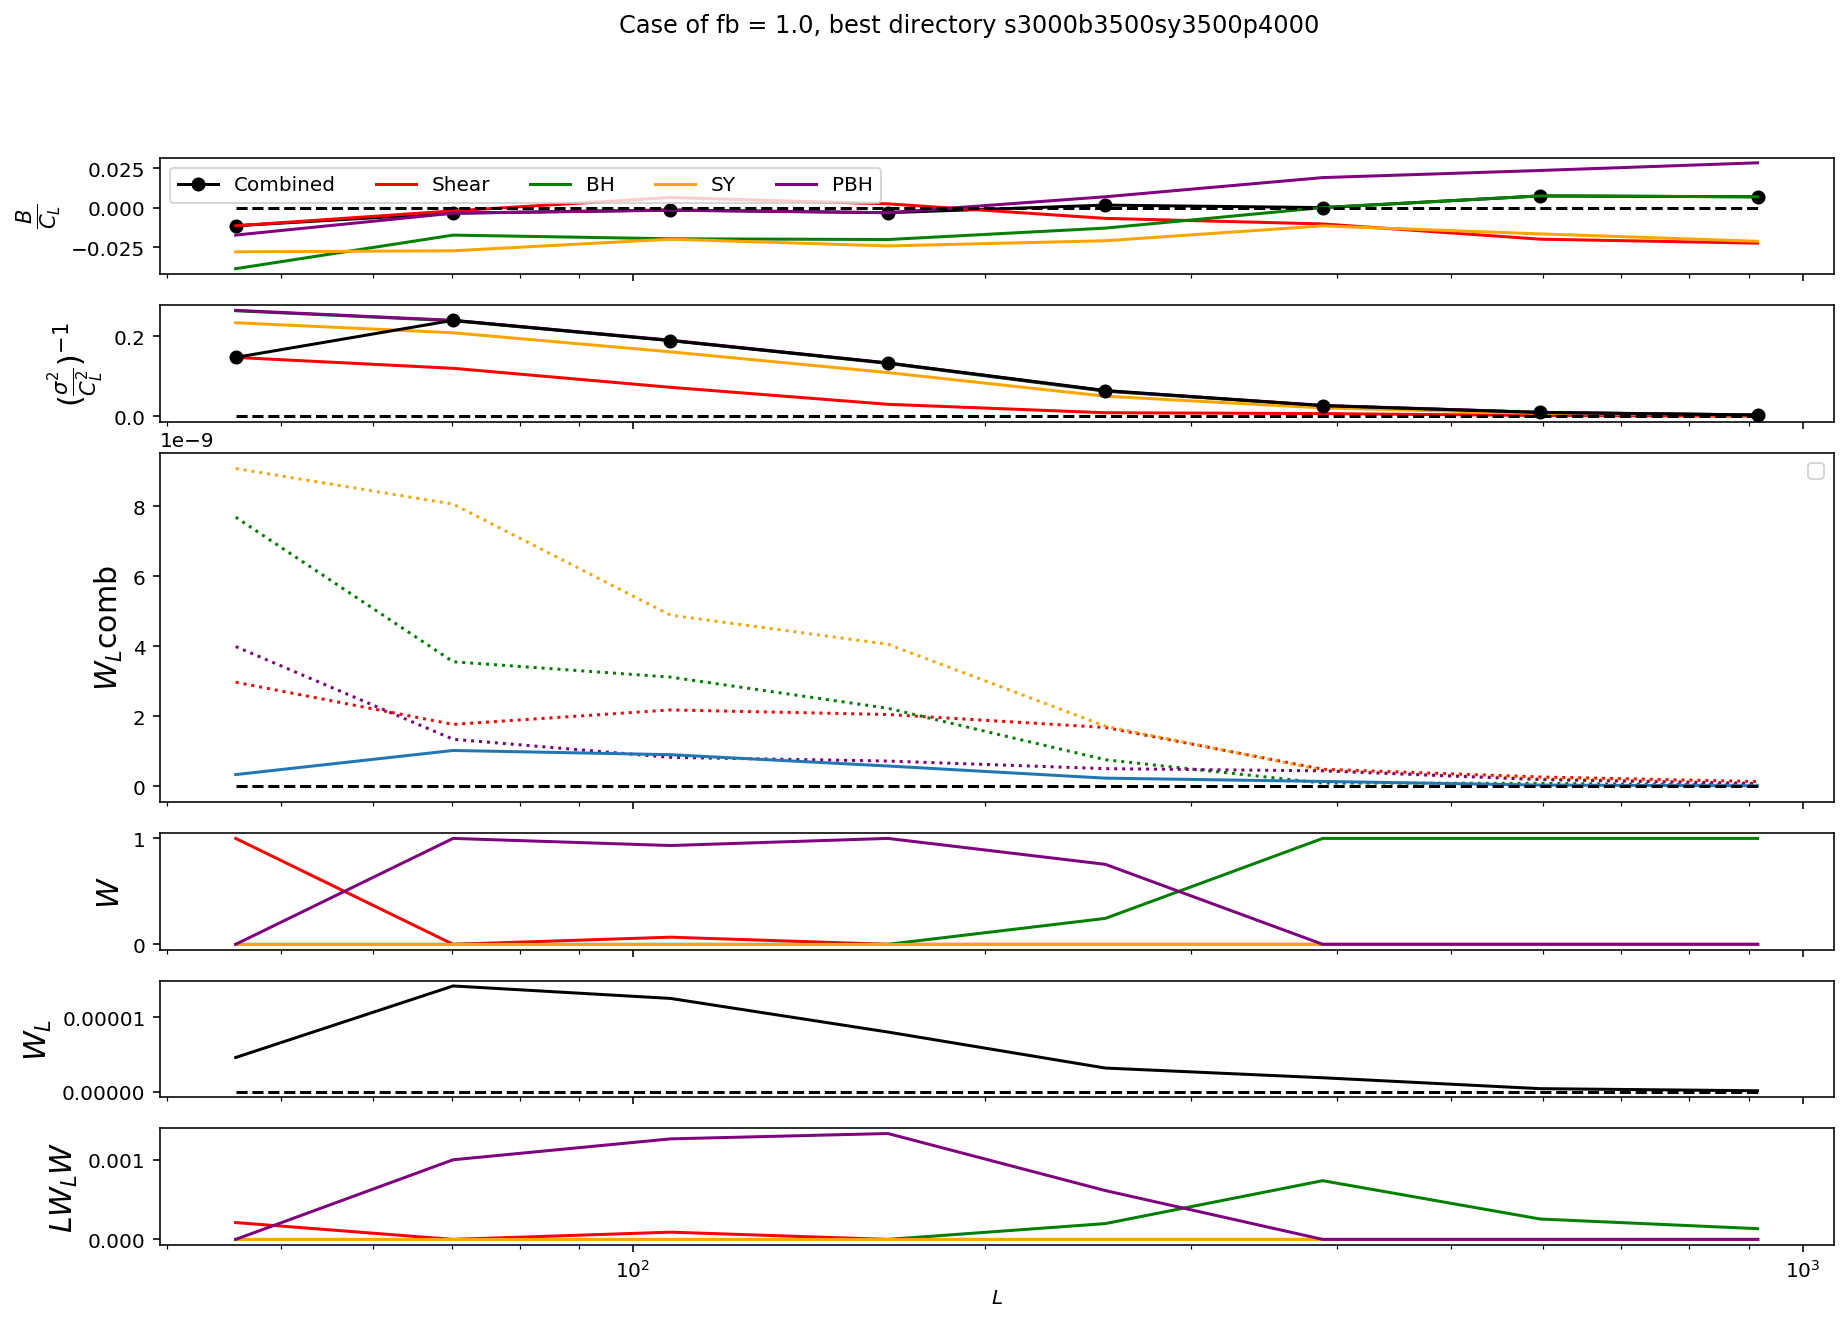

In [399]:
do_all(directory)

In [332]:
import pandas

In [333]:
all_results_single_array.shape

(4, 3, 256)

In [334]:
all_combs_array.shape

(3, 256)

In [335]:
f_ref, n_ref, b_ref

(0.00012393869064438422, 0.007748854554165684, -0.007993368735568874)

In [336]:
data = {}
data['Name'] = all_lmaxes_directories
data['Total Auto'] = all_combs_array[0]
data['Bias Auto'] = all_combs_array[2]
data['Noise Auto'] = all_combs_array[1]

data['Bias rtr'] =  np.round(abs(data['Bias Auto']/b_ref), 4)
data['Noise rtr'] =  np.round(abs(data['Noise Auto']/n_ref), 4)

data2 = data.copy()

for i, nome in enumerate(names):
    data[f'Bias {nome} rtr'] = np.round(abs(all_results_single_array[i, 2]/b_ref), 4)
    data[f'Noise {nome} rtr'] = np.round(abs(all_results_single_array[i, 1]/n_ref), 4)
    
for i, nome in enumerate(names):
    data2[f'Bias {nome} rtr'] = all_results_single_array[i, 2]
    data2[f'Noise {nome} rtr'] = all_results_single_array[i, 1]

In [337]:
print('Reference is HU OK ILC at 3000 (Relative to reference = rtr)')

Reference is HU OK ILC at 3000 (Relative to reference = rtr)


In [338]:
dframe = pandas.DataFrame(data)
dframe

,Name,Total Auto,Bias Auto,Noise Auto,Bias rtr,Noise rtr,Bias Shear rtr,Noise Shear rtr,Bias BH rtr,Noise BH rtr,Bias SY rtr,Noise SY rtr,Bias PBH rtr,Noise PBH rtr
0,s3000b4500sy3500p4000,0.000075,-0.001599,0.008492,0.2001,1.0959,0.6721,1.9949,1.4946,0.8957,2.4316,1.0888,1.2000,0.9704
1,s4500b4500sy3000p4000,0.000082,-0.003479,0.008385,0.4353,1.0821,0.9002,1.6846,1.4946,0.8957,1.6476,1.1768,1.2000,0.9704
2,s4500b3500sy3500p3000,0.000069,-0.000461,0.008318,0.0576,1.0734,0.9002,1.6846,1.0761,0.9796,2.4316,1.0888,0.8137,1.1995
3,s3000b3500sy3500p3000,0.000070,-0.000412,0.008327,0.0516,1.0746,0.6721,1.9949,1.0761,0.9796,2.4316,1.0888,0.8137,1.1995
4,s4000b4500sy4500p3500,0.000065,-0.000740,0.008004,0.0926,1.0329,0.8040,1.6918,1.4946,0.8957,2.9037,1.0707,0.0516,1.0314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,s4500b4500sy4000p4000,0.000089,-0.003783,0.008657,0.4733,1.1172,0.9002,1.6846,1.4946,0.8957,2.7617,1.0724,1.2000,0.9704
252,s4000b3500sy4000p3500,0.000064,-0.001417,0.007903,0.1773,1.0199,0.8040,1.6918,1.0761,0.9796,2.7617,1.0724,0.0516,1.0314
253,s3000b3000sy3500p4000,0.000072,-0.002330,0.008174,0.2915,1.0548,0.6721,1.9949,1.3965,1.1438,2.4316,1.0888,1.2000,0.9704
254,s4500b4500sy3500p3000,0.000120,-0.005076,0.009692,0.6351,1.2507,0.9002,1.6846,1.4946,0.8957,2.4316,1.0888,0.8137,1.1995


In [343]:
(-0.000210)**2.+0.008824**2.

7.7907076e-05

In [345]:
0.007704**2+(0.000503)**2.

5.9604625e-05

In [346]:
(7.8-5.7)/5.7

0.36842105263157887

In [339]:
dframe.sort_values(by = 'Total Auto')

,Name,Total Auto,Bias Auto,Noise Auto,Bias rtr,Noise rtr,Bias Shear rtr,Noise Shear rtr,Bias BH rtr,Noise BH rtr,Bias SY rtr,Noise SY rtr,Bias PBH rtr,Noise PBH rtr
112,s3000b3500sy3500p4000,0.00006,0.000503,0.007704,0.0629,0.9942,0.6721,1.9949,1.0761,0.9796,2.4316,1.0888,1.2000,0.9704
131,s3000b3500sy4000p4000,0.00006,0.000503,0.007704,0.0629,0.9942,0.6721,1.9949,1.0761,0.9796,2.7617,1.0724,1.2000,0.9704
54,s4500b3500sy4000p4000,0.00006,0.000483,0.007708,0.0605,0.9947,0.9002,1.6846,1.0761,0.9796,2.7617,1.0724,1.2000,0.9704
104,s4000b3500sy3500p4000,0.00006,0.000483,0.007708,0.0604,0.9948,0.8040,1.6918,1.0761,0.9796,2.4316,1.0888,1.2000,0.9704
99,s3500b3500sy4500p4000,0.00006,0.000483,0.007708,0.0605,0.9947,0.8087,1.7497,1.0761,0.9796,2.9037,1.0707,1.2000,0.9704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,s3500b4000sy3500p3000,0.00012,-0.005145,0.009658,0.6436,1.2463,0.8087,1.7497,0.0046,0.9224,2.4316,1.0888,0.8137,1.1995
79,s3500b4000sy4000p3000,0.00012,-0.005145,0.009658,0.6436,1.2463,0.8087,1.7497,0.0046,0.9224,2.7617,1.0724,0.8137,1.1995
43,s3500b4500sy3500p3000,0.00012,-0.005144,0.009658,0.6436,1.2463,0.8087,1.7497,1.4946,0.8957,2.4316,1.0888,0.8137,1.1995
162,s3500b4500sy4000p3000,0.00012,-0.005144,0.009658,0.6436,1.2463,0.8087,1.7497,1.4946,0.8957,2.7617,1.0724,0.8137,1.1995


Example is for pbh
Example is for pbh


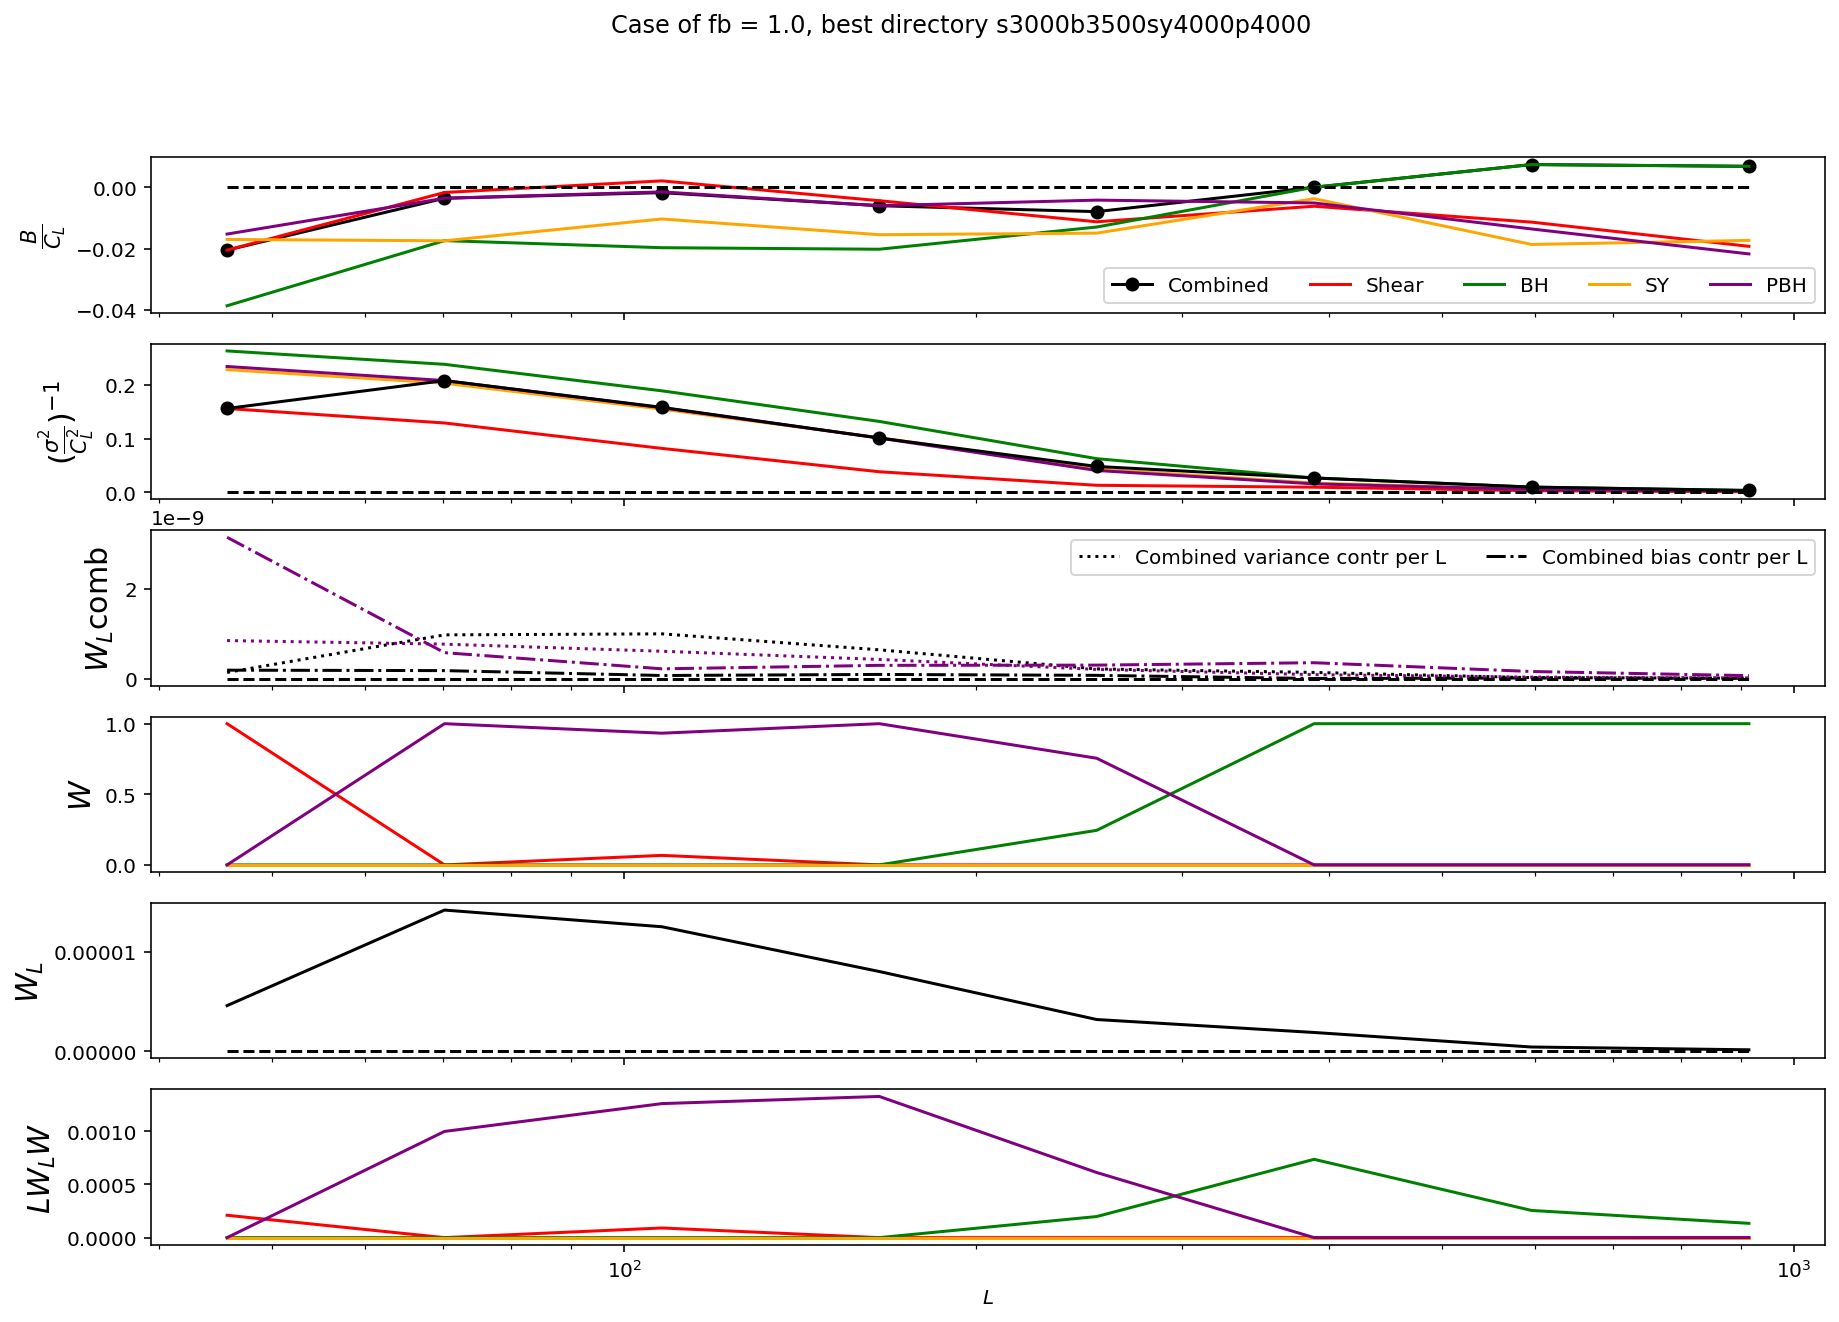

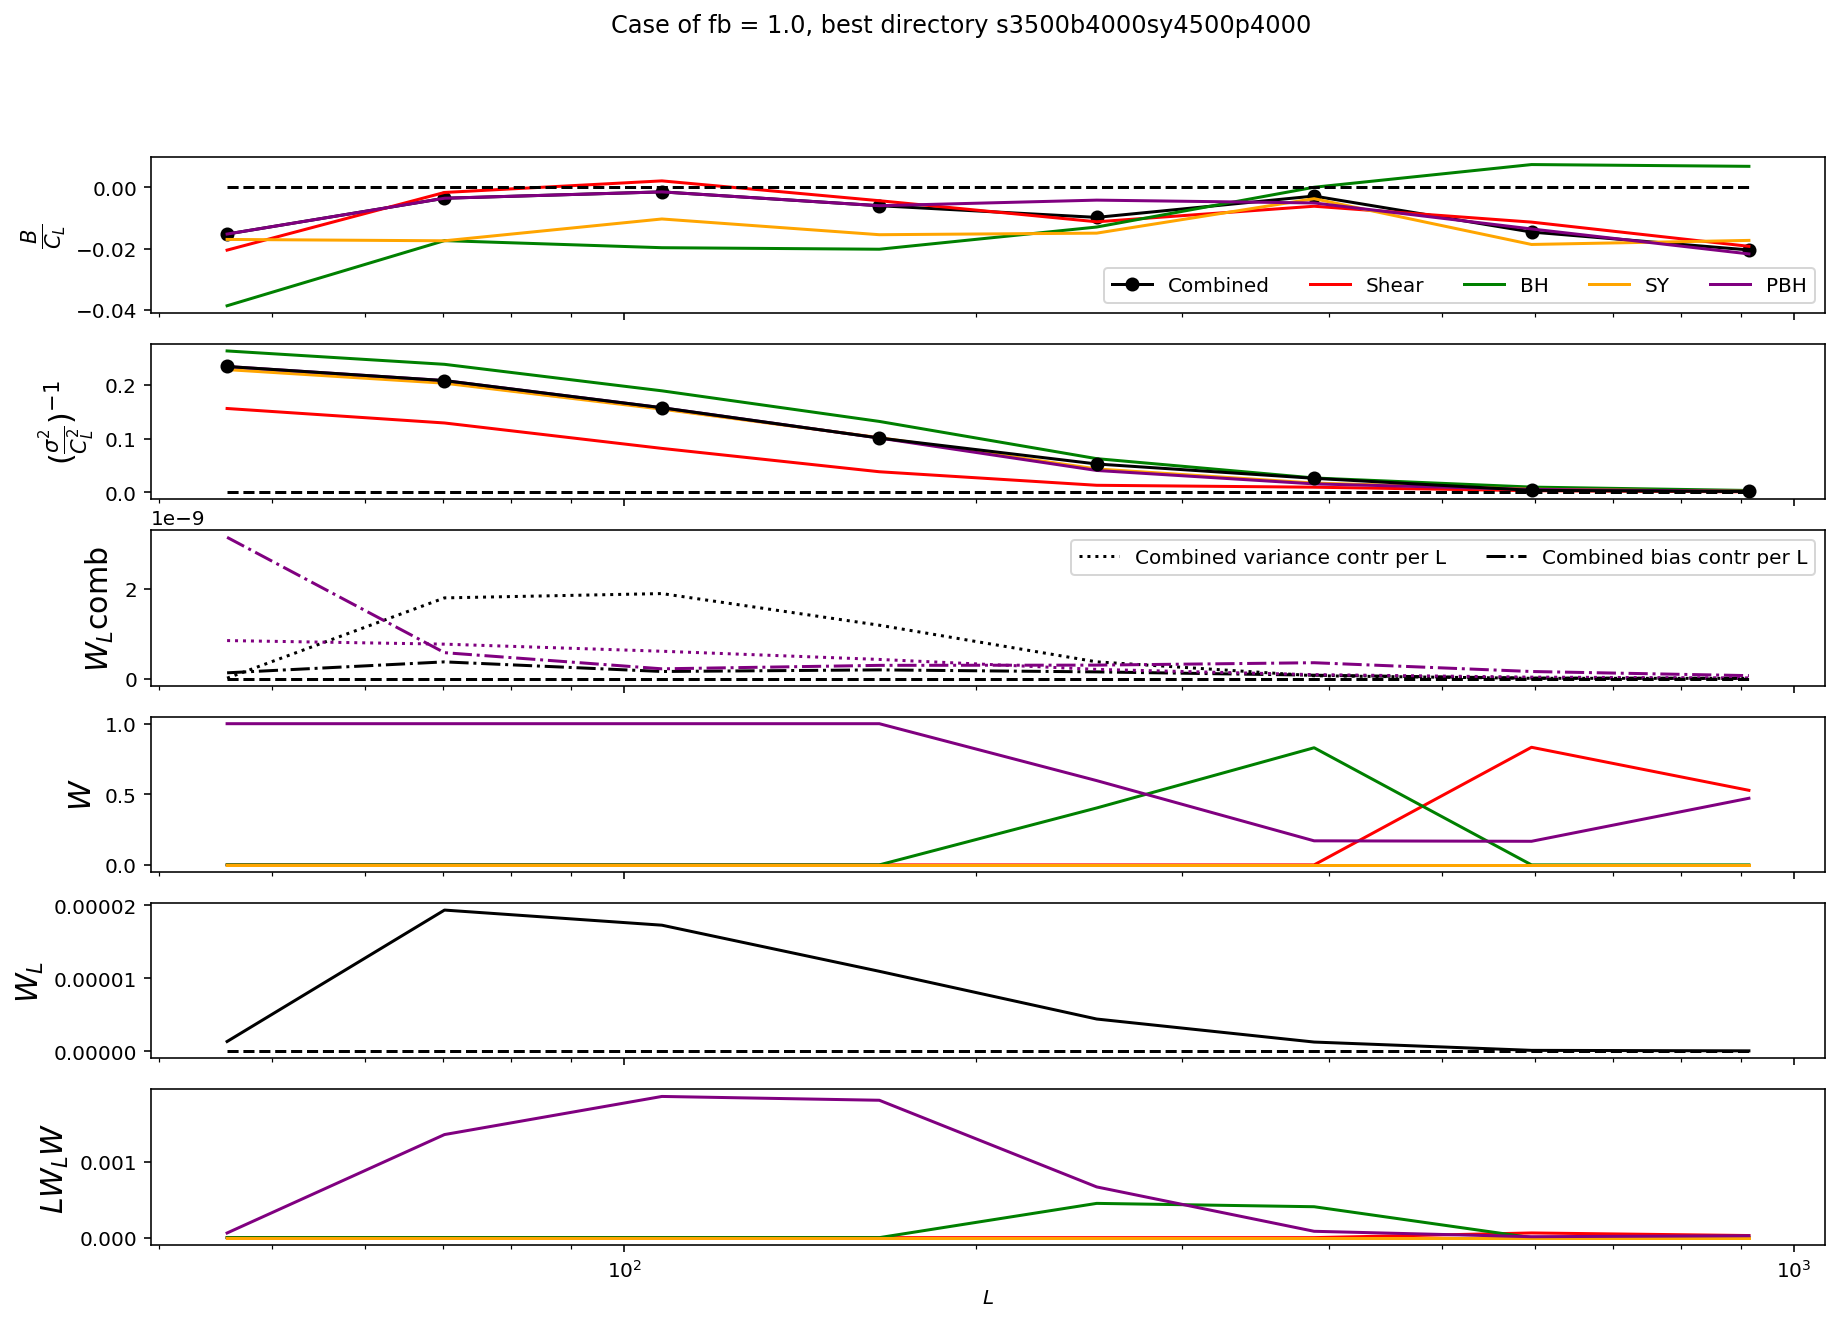

In [340]:
do_all('s3000b3500sy4000p4000')
do_all('s3500b4000sy4500p4000')

In [284]:
pandas.DataFrame(data2)

,Name,Total Auto,Bias Auto,Noise Auto,Bias rtr,Noise rtr,Bias Shear rtr,Noise Shear rtr,Bias BH rtr,Noise BH rtr,Bias SY rtr,Noise SY rtr,Bias PBH rtr,Noise PBH rtr
0,s3000b4500sy3500p4000,0.000075,-0.001599,0.008493,0.2001,1.0960,-0.005372,0.015458,0.011947,0.006941,-0.019437,0.008437,0.009592,0.007520
1,s4500b4500sy3000p4000,0.000082,-0.003479,0.008385,0.4353,1.0821,-0.007196,0.013054,0.011947,0.006941,-0.013169,0.009119,0.009592,0.007520
2,s4500b3500sy3500p3000,0.000069,-0.000460,0.008318,0.0576,1.0734,-0.007196,0.013054,-0.008602,0.007591,-0.019437,0.008437,-0.006504,0.009294
3,s3000b3500sy3500p3000,0.000934,-0.024821,0.017833,3.1052,2.3014,-0.005372,0.015458,-0.008602,0.007591,-0.019437,0.008437,-0.006504,0.009294
4,s4000b4500sy4500p3500,0.000065,-0.000741,0.008004,0.0926,1.0329,-0.006427,0.013109,0.011947,0.006941,-0.023210,0.008297,-0.000412,0.007992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,s4500b4500sy4000p4000,0.000089,-0.003783,0.008657,0.4732,1.1172,-0.007196,0.013054,0.011947,0.006941,-0.022076,0.008310,0.009592,0.007520
252,s4000b3500sy4000p3500,0.000064,-0.001417,0.007903,0.1773,1.0199,-0.006427,0.013109,-0.008602,0.007591,-0.022076,0.008310,-0.000412,0.007992
253,s3000b3000sy3500p4000,0.000066,-0.001282,0.008035,0.1603,1.0369,-0.005372,0.015458,-0.011163,0.008863,-0.019437,0.008437,0.009592,0.007520
254,s4500b4500sy3500p3000,0.000120,-0.005127,0.009657,0.6414,1.2463,-0.007196,0.013054,0.011947,0.006941,-0.019437,0.008437,-0.006504,0.009294
